# Ficheux 2020 single-qubit phases
In this tutorial we show how to ideally correct for single-qubit phases accumulated during the implementation of the CPHASE gate between two fluxonia using the Ficheux scheme. The notebook is adapted from the notebook Ficheux 2020.

In [26]:
import numpy as np
import sys
import time
import datetime
import qutip as qtp 
import cmath
import matplotlib.pyplot as plt
from scipy import constants
from scipy.optimize import minimize
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.util.phys import thermalenergy_to_temperature, temperature_to_thermalenergy
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
from IPython.display import display, Latex
from itertools import product, combinations

The gates will be based on the following driven Hamiltonian of capacitively coupled fluxonium and transmon

$$H = H_F + H_T + V + H_{drive}$$,

where we have the fluxonium Hamiltonian

$$H_L= 4 E_{C,F} \hat{n}^2_F + \frac{1}{2}E_{L} \hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \varphi_{ext,F}\right), \quad [\hat{\varphi}_F, \hat{n}_F] = i$$,

the transmon Hamiltonian (treated immediately as a Duffing oscillator)

$$H_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b}$$,

where in terms of the transmon's charging energy $E_{C,T}$ and Josephson energy $E_{J, T}$ the transmon's angular velocity $\omega_T$ and anharmonicity $\delta_T$ are

$$ \omega_T = \frac{\sqrt{8 E_{C, T} E_{J, T}}}{\hbar}, \quad \delta_T = - \frac{E_{C,T}}{\hbar} $$.
In addition, the transmon's charge operator can be written as
$$ \hat{n}_T = \frac{i}{2} \biggl( \frac{E_{J, T}}{2 E_{C, T}} \biggr)^{1/4} \bigl( \hat{b}^{\dagger} - \hat{b} \bigr) = \frac{i}{2} \sqrt{\frac{\omega_T}{4 \lvert \delta_T \rvert} }\bigl( \hat{b}^{\dagger} - \hat{b} \bigr).$$

The coupling Hamiltonian is

$$V = J_C  \hat{n}_F \hat{n}_T$$,

and the drive Hamiltonian

$$H_{drive} = 2  f\left( t \right)  \cos \left( \omega_d t + \gamma_d\right) \left( \eta_F  \hat{n}_F + \eta_T \hat{n}_T \right)   \text{  with  } f\left( t \right) = f_0 \dfrac{f\left( t \right)}{f_0}. $$

The energy levels should look like this :
<img src="energy_levels_03F_re-labeled.png" width="700">

# Single fluxonium and transmon

In [27]:
# Values in GHz (divided by h)
#Fluxonium A
ec_f = .973
el_f = .457
ej_f = 8.0 
flux_f = 1/2#pi in the cos
n_fock_f = 100

# Transmon parameters: values in GHz divided by 2 \pi 
omega_t = 4.5 #6.0 
delta_t = -0.3
n_fock_t = 3

In [28]:
levels_f = 5
levels_t = n_fock_t
flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=n_fock_f)
trans = pysqkit.qubits.SimpleTransmon('T', omega_t, delta_t, dim_hilbert=n_fock_t)
flx.diagonalize_basis(levels_f)

We obtain the energy levels and eigenstates of the two fluxonia

In [29]:
energies_f, eig_states_f = flx.eig_states(levels_f)
energies_t, eig_states_t = trans.eig_states(levels_t)

In [30]:
energies_in_lexico = np.zeros(levels_f*levels_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        energies_in_lexico[count] = energies_t[k] + energies_f[m]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)

label_converter = ascending_to_lexico
label_converter

array([ 0,  1,  5,  6,  2,  3, 10, 11,  7,  4,  8, 12, 13,  9, 14])

In [31]:
# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels_f: int,
    energies: np.ndarray,  #in ascending order
    label_converter: np.ndarray 
) -> float:
    label = k*levels_f + m #we use levels_f to ensure bijectivity (ex for t:2, f:4)
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels_f: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray 
) -> float:
    label = k*levels_f + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return eig_states[index] 

def energy_ascending_order_to_label(
    k : int,
    levels_f: int,
    label_converter : np.ndarray):
    
    lexico_rank = label_converter[k]
    i = lexico_rank//levels_f
    j = lexico_rank%levels_f
    
    return i, j

# Adding drives

In [32]:
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive_f',
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)
trans.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive_t',
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

# Coupled fluxonium and transmon

In [33]:
jc = 0.07 #GHz (divided by h)

coupled_sys = trans.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_sys.eig_states() 

coupled_sys_bare = trans.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_sys_bare.eig_states()

# Jump operators and relaxation rates

In [34]:
temperature = 0.020 # K
en_th = temperature_to_thermalenergy(temperature) # kb T/h in GHz
tan_deltac_f = 7.1*1e-6 
tan_deltac_t = 0.75*1e-6 
qdiel_f = 1/tan_deltac_f
qdiel_t = 1/tan_deltac_t

In [35]:
rel_rate_f, exc_rate_f, gamma_f = flx.dielectric_rates(level_k=0, level_m=1, qdiel=qdiel_f, beta=1/en_th)
rel_rate_t, exc_rate_t, gamma_t = trans.dielectric_rates(level_k=0, level_m=1, qdiel=qdiel_t, beta=1/en_th)
t1_f = 1/(2*np.pi)*1/rel_rate_f/1000 # [mu s]
t1_t = 1/(2*np.pi)*1/rel_rate_t/1000 # [mu s]

In [36]:
display(Latex(r'$T_{{1}}^{{a}} $ = {:.3f} $\mu s$'.format(t1_f)))
display(Latex(r'$T_{{1}}^{{b}} $ = {:.3f} $\mu s$'.format(t1_t)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [51]:
trans_jumps = trans.dielectric_loss(qdiel_t, 1/en_th, as_qobj=True)
flx_jumps = flx.dielectric_loss(qdiel_f, 1/en_th, as_qobj=True)
jumps = []
for op in trans_jumps:
    jumps.append(qtp.tensor(op, qtp.qeye(levels_f)) )
for op in flx_jumps:
    jumps.append(qtp.tensor(qtp.qeye(levels_t), op) )

### Remark 
The relaxation time of the fluxonium is now very large, keeping the estimated loss tangent fixed as in the Ficheux paper. This is expected since we are now operating at higher $E_J$ and so with a higher barrier. Notice also that now the frequency of the fluxonium is very small

In [52]:
display(Latex(r'$\omega_{{01}}^{{f}}/2 \pi $ = {:.3f} $\mathrm{{GHz}}$'.format(energies_f[1] - energies_f[0])))

<IPython.core.display.Latex object>

This would make the single-qubit gates harder, so maybe it should be increased a bit by increasing $E_L$. Additionally, at the beginning we will use a constant loss tangent. However, that has a dependency with frequency, so we have to be careful when we compare performances with different parameters.

## Drive

In [53]:
eig_states_by_label = []
energies_by_label = []

for i_a in range(levels_t):
    energies_by_label.append([])
    eig_states_by_label.append([])
    for i_b in range(levels_f):
        eig_states_by_label[i_a].append(qtp.Qobj(inpt=  label_to_states(i_a, i_b, levels_f, eigstates_sys, label_converter), 
                   dims=[[levels_t, levels_f], [1, 1]], shape=[levels_t*levels_f, 1]))
        energies_by_label[i_a].append(label_to_states(i_a, i_b, levels_f, energies_sys, label_converter))

In [54]:
n_f = coupled_sys['F'].charge_op(as_qobj=True)
n_t = coupled_sys['T'].charge_op(as_qobj=True)
n_charge = [n_f, n_t]

In [55]:
big_delta = ( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
              label_to_energies(1, 0, levels_f, energies_sys, label_converter) ) - \
            ( label_to_energies(0, 3, levels_f, energies_sys, label_converter)   - \
              label_to_energies(0, 0, levels_f, energies_sys, label_converter) )

display(Latex(r'$\Delta/2\pi $ = {:.3f} MHz'.format(big_delta*1000)))

<IPython.core.display.Latex object>

For this case we look at the 10-13 and 00-03 transitions so we process the corresponding Rabi frequencies :

$$\Omega_{10-13}  = \left| \epsilon_T \langle 10 | \hat{n}_T | 13 \rangle + \epsilon_F \langle 10 | \hat{n}_F | 13 \rangle \right|$$
$$\Omega_{00-03}  = \left| \epsilon_T \langle 00 | \hat{n}_T | 03 \rangle + \epsilon_F \langle 00 | \hat{n}_F | 03 \rangle \right|$$

And then :
$$r = \dfrac{\Omega_{10-13}}{\Omega_{00-03}} \text{  and  } \dfrac{\delta}{\Delta} = \dfrac{r^2 - \sqrt{(r^2-1)^2 + r^2 }} {r^2 - 1}$$ 

With these conventions taken in the paper :
$$\Delta = f_{10-13} - f_{00-03}$$
$$\delta = f_{10-13} - f_d$$

These conventions are taken in orde to have : $\Omega = \sqrt{\Omega_{10-13}^2  + \delta^2} = \sqrt{\Omega_{00-03}^2  + (\delta - \Delta)^2}$

The $\Delta$ is fixed by the parameters of the qubits, we now need to settle the values for the drive parameters.

First we need to fix the $\varepsilon$.

We take the condition of the paper :
$$\Omega = \Delta$$

However, one equation for two parameters is not enough... We assume that the fluxonium is driven much more than the transmon (as we are mainly looking at the 0-3 transtion of F). For example, we take $\dfrac{\varepsilon_T}{\varepsilon_F} = .1$
Now we have enough constraints to find values for every parameters.


With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$

We now match the conditions

In [56]:
def Omega1(eps_f, eps_t_over_eps_f):
    eps_t = eps_f * eps_t_over_eps_f
    eps = [eps_t, eps_f]
    
    rabi_10_13 = np.abs(eps[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[1][3]).full()[0, 0] + \
                          eps[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[1][3]).full()[0, 0] )
    rabi_00_03 = np.abs(eps[0] * (eig_states_by_label[0][0].dag() * n_charge[0] * eig_states_by_label[0][3]).full()[0, 0] + \
                          eps[1] * (eig_states_by_label[0][0].dag() * n_charge[1] * eig_states_by_label[0][3]).full()[0, 0] )
    rabi_ratio = rabi_10_13/rabi_00_03
    ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1) 
    
    big_delta = ( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
              label_to_energies(1, 0, levels_f, energies_sys, label_converter) ) - \
            ( label_to_energies(0, 3, levels_f, energies_sys, label_converter)   - \
              label_to_energies(0, 0, levels_f, energies_sys, label_converter) )
    small_delta = big_delta * ratio_delta
    
    return np.sqrt(rabi_10_13**2 + small_delta**2)

def Omega2(eps_f, eps_t_over_eps_f):
    eps_t = eps_f * eps_t_over_eps_f
    eps = [eps_t, eps_f]
    
    rabi_10_13 = np.abs(eps[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[1][3]).full()[0, 0] + \
                          eps[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[1][3]).full()[0, 0] )
    rabi_00_03 = np.abs(eps[0] * (eig_states_by_label[0][0].dag() * n_charge[0] * eig_states_by_label[0][3]).full()[0, 0] + \
                          eps[1] * (eig_states_by_label[0][0].dag() * n_charge[1] * eig_states_by_label[0][3]).full()[0, 0] )
    rabi_ratio = rabi_10_13/rabi_00_03
    ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1) 
    
    
    small_delta = big_delta * ratio_delta
    
    return np.sqrt(rabi_00_03**2 + (small_delta - big_delta)**2)

## Rest of parameters

In [57]:
ratio_eps = .0
eps_f = 0.03091755984900732
eps_t = ratio_eps*eps_f
eps = [eps_f, eps_t]
rabi_10_13 = np.abs(eps[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[1][3]).full()[0, 0] + \
                          eps[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[1][3]).full()[0, 0] )

rabi_00_03 = np.abs(eps[0] * (eig_states_by_label[0][0].dag() * n_charge[0] * eig_states_by_label[0][3]).full()[0, 0] + \
                          eps[1] * (eig_states_by_label[0][0].dag() * n_charge[1] * eig_states_by_label[0][3]).full()[0, 0] )

rabi_ratio = rabi_10_13/rabi_00_03
print("The rabi frequencies are : Omega_10_13 =", rabi_10_13, "GHz  ; Omega_00_03 =", rabi_00_03, 
      "GHz \nSo we have : r =", rabi_ratio)

ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
print("\ndelta/Delta =", ratio_delta)

The rabi frequencies are : Omega_10_13 = 0.019006434288465615 GHz  ; Omega_00_03 = 0.02032488624441926 GHz 
So we have : r = 0.935131152022282

delta/Delta = 0.5500582706475864


In [58]:
small_delta = big_delta * ratio_delta

freq_drive = ( label_to_energies(1, 3, levels_f, energies_sys, label_converter)   - \
               label_to_energies(1, 0, levels_f, energies_sys, label_converter) )  - small_delta

t_drive = 1/big_delta

display(Latex(r'$\Delta/2\pi $ = {:.3f} MHz'.format(big_delta*1000)))
display(Latex(r'$\delta/2\pi $ = {:.3f} MHz'.format(small_delta*1000)))
display(Latex(r'$\omega_d/2\pi $ = {:.3f} GHz'.format(freq_drive)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We can indeed check that with this procedure the rabi frequencies for the two relevant transitions are matched and equal to $\Delta$ (to a good approximation)

In [59]:
rabi_freq_10_13 = np.sqrt(rabi_10_13**2 + small_delta**2)
rabi_freq_00_03 = np.sqrt(rabi_00_03**2 + (small_delta - big_delta)**2)
display(Latex(r'$\Omega_{{10-13}}/2\pi $ = {:.3f} MHz'.format(rabi_freq_10_13*1000)))
display(Latex(r'$\Omega_{{00-03}}/2\pi $ = {:.3f} MHz'.format(rabi_freq_00_03*1000)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [60]:
rabi_freq = big_delta

rabi_period = 1/rabi_freq # [ns]
display(Latex(r'$T_{{Rabi}} $ = {:.3f} ns'.format(rabi_period)))

<IPython.core.display.Latex object>

#  Simulations

In [73]:
t_rise = 0.1#16.0
t_tot = rabi_period*1000
# t_plateau = t_tot - 2*t_rise
# simulation setup (noiseless)
pts_per_drive_period = 15

nb_points = int(t_tot*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_tot, nb_points)
pulse_drive = np.zeros(nb_points, dtype=float)

interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,2], [0,3], [1,3], [2,0]]
labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in interest_levels]

hamil0 = coupled_sys.hamiltonian(as_qobj=True)
coupled_sys['F'].drives['cz_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise)
coupled_sys['T'].drives['cz_drive_t'].set_params(phase=0, time=tlist, rise_time=t_rise)

In [74]:
drive_params = dict(
    cz_drive_f=dict(amp=eps_f, freq=freq_drive),
    cz_drive_t=dict(amp=eps_t, freq=freq_drive)
)

drive_hamils = []
pulses = []

for qubit in coupled_sys:
    if qubit.is_driven:
        for label, drive in qubit.drives.items():
            drive_hamils.append(drive.hamiltonian(as_qobj=True))
            pulses.append(drive.eval_pulse(**drive_params[label]))


In [ ]:
state_in = []
outputs = []
for i in range(0, 2):
    for k in range(0, 2):
        state_in.append(eig_states_by_label[i][k])
for i in range(0, 4):
    outputs.append(solvkit.integrate(tlist*2*np.pi, state_in[i], hamil0, drive_hamils, pulses, jumps, "mesolve"))

In [71]:
statein_label = '11'
statein_index = int(statein_label, 2)
rhos_by_label = []
for i in range(len(eig_states_by_label)):
    rhos_by_label.append([])
    for j in range(len(eig_states_by_label[0])):
        rhos_by_label[i].append(eig_states_by_label[i][j]*eig_states_by_label[i][j].dag())  
        
probs = np.zeros([len(labels), nb_points], dtype=float)
for k in range(0, len(labels)):
    i, j = interest_levels[k]
    for m in range(0, nb_points):        
        probs[k, m] = qtp.expect(rhos_by_label[i][j], outputs[statein_index].states[m]) 

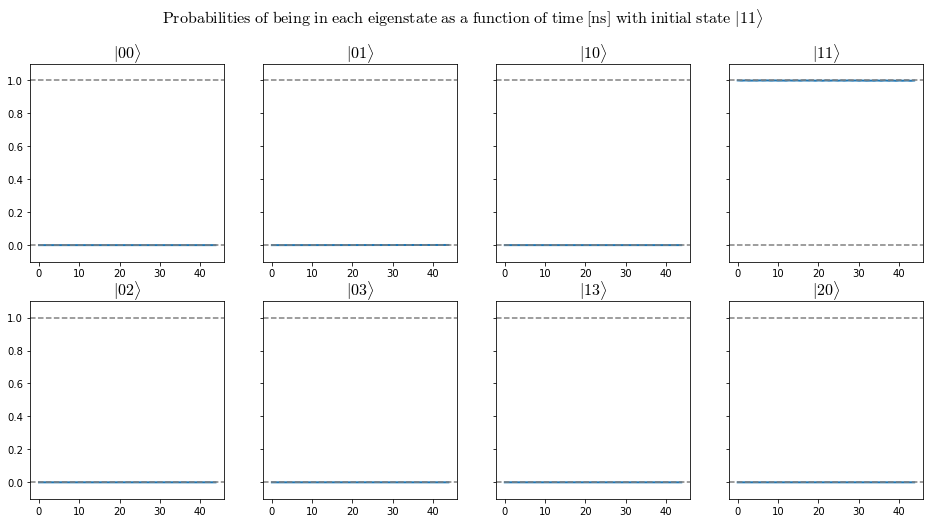

In [72]:
plot_setup = {'lw': 2.0, 'fs': 16, 'fs_text': 14, 'ls': 14}
def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray,
    statein_label: str,
    opt: dict
) -> None:
    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = (16, 8))
    for k in range(0, len(labels)):
        ax[k//4, k%4].plot(tlist, probs[k, :], linewidth=opt['lw'])

        ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title(labels[k], fontsize=opt['fs'])
        ax[k//4, k%4].set_ylim(-0.1, 1.1)
        ax[k//4, k%4].axhline(y=0, color='grey', linestyle='--')
        ax[k//4, k%4].axhline(y=1, color='grey', linestyle='--')

        if k%4 != 0:
            ax[k//4, k%4].axes.yaxis.set_ticklabels([])

    fig = plt.gcf()
    fig.suptitle('$\mathrm{Probabilities \ of \ being \ in \ each \ eigenstate \
                 \ as \ a \ function \ of \ time \ [ns] \ with \ initial \ state}$' + 
                 ' $\\vert ' + statein_label + ' \\rangle$', fontsize=opt['fs']) 
    plt.show()

plot_probas(tlist, probs, statein_label, plot_setup)

In [66]:
u_gate = np.zeros([4, 4], dtype=complex)
for i in range(0, 4):
    for k in range(0, 4):
        u_gate[i, k] = (state_in[i].dag()*outputs[k].states[nb_points - 1])[0, 0]
u_ideal_phases = np.zeros([4, 4], dtype=complex)
for i in range(0, 2):
    for k in range(0, 2):
        n = i*2 + k
        u_ideal_phases[n, n] = np.exp(-1j*2*np.pi*energies_by_label[i][k]*t_tot)

#taking out phase associated with 00 from numerical simulations
u_ideal_phases = np.conj(u_gate[0, 0])*u_ideal_phases
u_gate = np.conj(u_gate[0, 0])*u_gate 

We now detail how to obtain the single-qubit gates in order to bring the (ideal) gate to the CZ form
$$
\mathrm{CZ} = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}
$$
The Ficheux protocol we have just simulated realizes (ideally) a unitary 
$$
U =  \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & e^{i \phi_{01}} & 0 & 0 \\
0 & 0 & e^{i \phi_{10}} & 0 \\
0 & 0 & 0 & e^{i \phi_{11}}
\end{pmatrix}
$$
where the phases satisfy the condition
$$
\phi_{11} - \phi_{01} - \phi_{10} = \pi \mod 2 \pi.
$$
Let us define a generic single-qubit phase gate
$$
P(\phi) = \begin{pmatrix}
1 & 0 \\
0 & e^{i \phi}
\end{pmatrix}.
$$
The single-qubit gates to be applied are $P(-\phi_{01})$ on the second qubit and $P(-\phi_{10})$ on the first qubit (to see it more clearly apply them sequentially). In fact, one can check that 
$$
P(-\phi_{10}) \otimes P(-\phi_{01}) U = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{i (\phi_{11} - \phi_{10} - \phi_{01})}
\end{pmatrix},
$$
which given the previous condition on the phases is equal to the CZ gate. Notice that this is the same as in Ficheux although the levels are different.


In [67]:
def single_qubit_correction(
    u_gate: np.ndarray
) -> np.ndarray:
    phi_10 = cmath.phase(u_gate[2, 2])
    phi_01 = cmath.phase(u_gate[1, 1])
    p_phi10 = np.array([[1, 0], [0, np.exp(-1j*phi_10)]])
    p_phi01 = np.array([[1, 0], [0, np.exp(-1j*phi_01)]])
    return tensor_prod([p_phi10, p_phi01])

In [68]:
cz = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])
u_correction = single_qubit_correction(u_gate)
u_ideal = qtp.Qobj(u_correction.conj().T.dot(cz))
sup_u_ideal = qtp.to_super(u_ideal)

In [69]:
u_ideal

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.48689098+0.87346275j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.57306289+0.81951139j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.43679352+0.8995618j ]]

In [70]:
np.diag(u_gate)

array([ 9.93005825e-01+0.00000000e+00j, -7.79706549e-06+1.39876205e-05j,
       -5.31901906e-05+7.60648919e-05j, -1.43951099e-04+1.17517774e-07j])

In [43]:
pippo, pluto = flx.dielectric_jump(0, 1, qdiel_f, 1/en_th, as_qobj=True)

In [44]:
pippo

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[ 6.61776534e-18  4.07929754e-04 -1.30206739e-19  8.47405271e-20
  -4.52893005e-20]
 [-1.07358725e-31 -6.61776534e-18  2.11231869e-33 -1.37472915e-33
   7.34719546e-34]
 [-1.21464185e-32 -7.48724870e-19  2.38984832e-34 -1.55534966e-34
   8.31251590e-35]
 [-3.33381112e-34 -2.05501507e-20  6.55938450e-36 -4.26894725e-36
   2.28152504e-36]
 [ 7.35315594e-32  4.53260419e-18 -1.44675794e-33  9.41572084e-34
  -5.03220153e-34]]

In [36]:
pluto

array([[ 6.42207224e-18, -1.04184033e-31, -1.17872383e-32,
        -3.23522741e-34,  7.13571669e-32],
       [ 3.95866914e-04, -6.42207224e-18, -7.26584421e-19,
        -1.99424647e-20,  4.39857112e-18],
       [-1.26356412e-19,  2.04985558e-33,  2.31917842e-34,
         6.36541776e-36, -1.40397604e-33],
       [ 8.22346756e-20, -1.33407721e-33, -1.50935661e-34,
        -4.14271074e-36,  9.13728974e-34],
       [-4.39500563e-20,  7.12993246e-34,  8.06670754e-35,
         2.21405835e-36, -4.88339493e-34]])